# PyTorch DL Models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# keras
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import set_random_seed

# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## 1. Data Preprocessing

In [ ]:
X = np.load('/kaggle/input/twitter-preprocessed/feature_vectors_neg.npy', allow_pickle=True)
y = np.load('/kaggle/input/twitter-preprocessed/target_vectors_neg.npy', allow_pickle=True)

In [5]:
print(X.shape)
print(y.shape)

(1590780,)
(1590780,)


In [6]:
X_train_split, X_test_split, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=13)
X_test_split, X_val_split, y_test, y_val = train_test_split(X_test_split, y_test, train_size=0.5, random_state=13)

print("Train set size:", X_train_split.shape[0])
print("Test set size", X_test_split.shape[0])
print("Validation set size", X_val_split.shape[0])

Train set size: 1431702
Test set size 79539
Validation set size 79539


In [7]:
# Initiate Keras tokenizer and vectorizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_split)

# Transfrom X into vectorized values
X_train_transformed = tokenizer.texts_to_sequences(X_train_split)
X_val_transformed = tokenizer.texts_to_sequences(X_val_split)
X_test_transformed = tokenizer.texts_to_sequences(X_test_split)

# View vocabulary size
print("Vocabulary size: ", len(tokenizer.word_index))

Vocabulary size:  235887


In [8]:
X_train_split[0]

'wish could say yum NEGlike fruit'

In [9]:
X_train_transformed[0]

[45, 44, 90, 783, 323, 2166]

In [10]:
# Initiate the label encoder to convert target data into (0, 1) instead of (0, 4)
label_encoder = LabelEncoder()

# Transform y into numerical values (0, 1)
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

### Padding and Truncation
Length of the word vectors are unenven.

In [11]:
print('Statistics summary of vector lengths in X_transformed: ')
pd.Series([len(text.split()) for text in X]).describe(percentiles=[.25, .5, .75, .9, .975]).apply("{0:.2f}".format)

Statistics summary of vector lengths in X_transformed: 


count    1590780.00
mean           6.83
std            3.77
min            1.00
25%            4.00
50%            6.00
75%            9.00
90%           12.00
97.5%         15.00
max           50.00
dtype: object

In [12]:
# Perform padding on X_transformed
X_train_transformed = pad_sequences(X_train_transformed, maxlen=25, padding='post', truncating='post')
X_val_transformed = pad_sequences(X_val_transformed, maxlen=25, padding='post', truncating='post')
X_test_transformed = pad_sequences(X_test_transformed, maxlen=25, padding='post', truncating='post')

print('Statistics summary of vector lengths in X_transformed: ')
pd.Series([len(text) for text in X_train_transformed]).describe().apply("{0:.2f}".format)

Statistics summary of vector lengths in X_transformed: 


count    1431702.00
mean          25.00
std            0.00
min           25.00
25%           25.00
50%           25.00
75%           25.00
max           25.00
dtype: object

In [13]:
train_set = TensorDataset(torch.tensor(X_train_transformed), torch.tensor(y_train).reshape(-1, 1))
val_set = TensorDataset(torch.tensor(X_val_transformed), torch.tensor(y_val).reshape(-1, 1))
test_set = TensorDataset(torch.tensor(X_test_transformed), torch.tensor(y_test).reshape(-1, 1))

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128)
test_loader = DataLoader(test_set, batch_size=128)

### FastText word embeddings
In order to load vectors from a file, we use `KeyedVectors` API of Gensim. The word we want to lookup is the key, and the numerical representation of the word is the corresponding vectors.


In [14]:
# gensim FastText word embeddings
from gensim.models import KeyedVectors
kv_model = KeyedVectors.load_word2vec_format('/kaggle/input/fasttext-word-embeddings/crawl-300d-2M.vec')

- Let us build the embedding word vectors from our built vocabulary.
- We loop through each item in our vocabulary to see if our embedding model has the embedding vectors for it.
- If yes, we may load it into our embeddings matrix; otherwise we leave it empty (fill with zeroes)

In [15]:
VOCAB_SIZE = len(tokenizer.word_index) + 1
EMBEDDINGS_DIM = 300

In [16]:
"apple" in kv_model

True

In [17]:
# Initialise an empty matrix as an embeddings container
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDINGS_DIM))

# Loading GloVe weights into our embedding matrix
for word, index in tokenizer.word_index.items():
  if word in kv_model:
    embedding_matrix[index] = kv_model[word].copy()

embedding_matrix = torch.FloatTensor(embedding_matrix)


In [18]:
embedding_matrix.shape

torch.Size([235888, 300])

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [20]:
torch.manual_seed(13)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(13)
# Ensure cudnn uses deterministic algorithms only
torch.backends.cudnn.deterministic = True
# Disable cudnn benchmark mode. This ensures that cudnn does not look for the best
# convolution algorithm for the hardware.
torch.backends.cudnn.benchmark = False

In [21]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  total_train_loss = 0.0
  total_train_acc = 0.0
  model.train()

  for batch, (X, y) in enumerate(dataloader):
    if torch.cuda.is_available():
      X, y = X.to(device), y.to(device)
    pred = model(X)
    loss = loss_fn(pred, y.float())
    total_train_loss += loss.item()
    total_train_acc += ((pred > 0.5) == y).sum()

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch%1000 == 0:
      loss, current = loss.item(), batch * BATCH_SIZE + len(X)
      print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
  total_train_loss /= len(dataloader)
  total_train_acc /= size
  return total_train_loss, total_train_acc

In [22]:
def test_loop(dataloader, model, loss_fn):
  model.eval()
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  total_test_loss, total_test_acc = 0.0, 0.0

  with torch.no_grad():
    for X, y in dataloader:
      if torch.cuda.is_available():
        X, y = X.to(device), y.to(device)
      pred = model(X)
      total_test_loss += loss_fn(pred, y.float()).item()
      total_test_acc += ((pred > 0.5) == y).sum()

  total_test_loss /= num_batches
  total_test_acc /= size
  print(f"Test Error:\n Accuracy: {(100*total_test_acc):>0.5f}%, Avg. loss: {total_test_loss:>8f}\n")
  return total_test_loss, total_test_acc

### 2. Feed Forward Neural Network

In [ ]:
# The output of the model [0, 1]
OUTPUT_SIZE = 1
# The size of the hidden layers
HIDDEN_SIZE = 512
# Batch Size
BATCH_SIZE = 128
# Number of epochs
NUM_EPOCHS = 50

### Building the Neural Network
- 2 layers (512 and 256 hidden nodes)
- 1 node in the output layer.
- 1 embedding layer to transform our input sequence into word embeddings.
- Since the word embeddings will create a vector for each token, we need a way to aggregate vectors inot one single vector (**POOLING**).
  - There are many ways to do this such as taking the mean of the vectors, taking sum etc.
  - But, here we are summing them up in order to take care of OOV words.
- We are also applying *dropout* in order to regularize the model, ensuring that there is a lower chance of overfitting.
  - The main idea is to randomly dropout a percentage of all connections between layers, therefore the model only learns to generalize features but not to replicate them.

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, output_size, embedding_dim, hidden_size, dropout=0.5):
    super().__init__()
    self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(in_features = embedding_dim, out_features = hidden_size),
        nn.ReLU(),
        nn.Dropout(p = dropout),
        nn.Linear(in_features = hidden_size, out_features=hidden_size//2),
        nn.ReLU(),
        nn.Linear(in_features=hidden_size//2, out_features = output_size, bias = False),
        nn.Sigmoid()
    )
  def forward(self, input):
    emb = self.embedding(input)
    emb = torch.sum(emb, dim = 1)
    out = self.linear_relu_stack(emb)
    return out

ff_model = FeedForward(OUTPUT_SIZE, EMBEDDINGS_DIM, HIDDEN_SIZE, 0.5).to(device)
print(ff_model)

FeedForward(

  (embedding): Embedding(248717, 300)

  (linear_relu_stack): Sequential(

    (0): Linear(in_features=300, out_features=512, bias=True)

    (1): ReLU()

    (2): Dropout(p=0.5, inplace=False)

    (3): Linear(in_features=512, out_features=256, bias=True)

    (4): ReLU()

    (5): Linear(in_features=256, out_features=1, bias=False)

    (6): Sigmoid()

  )

)


In [ ]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(ff_model.parameters(), lr = 1e-4, weight_decay=1e-7)
epochs = 10
train_loss_arr, train_acc_arr = [], []
val_loss_arr, val_acc_arr = [], []

for t in range(epochs):
  print(f"Epoch {t+1}\n---------------------------")
  train_loss, train_acc = train_loop(train_loader, ff_model, loss_fn, optimizer)
  val_loss, val_acc = test_loop(val_loader, ff_model, loss_fn)
  train_loss_arr.append(train_loss)
  train_acc_arr.append(train_acc)
  val_loss_arr.append(val_loss)
  val_acc_arr.append(val_acc)
print("Done")


Epoch 1

---------------------------

loss: 0.695539 [  128/1432690]

loss: 0.465368 [128128/1432690]

loss: 0.531527 [256128/1432690]

loss: 0.509258 [384128/1432690]

loss: 0.514376 [512128/1432690]

loss: 0.478203 [640128/1432690]

loss: 0.439991 [768128/1432690]

loss: 0.507621 [896128/1432690]

loss: 0.493957 [1024128/1432690]

loss: 0.478954 [1152128/1432690]

loss: 0.483383 [1280128/1432690]

loss: 0.506860 [1408128/1432690]

Test Error:

 Accuracy: 78.75343%, Avg. loss: 0.453631



Epoch 2

---------------------------

loss: 0.464294 [  128/1432690]

loss: 0.353353 [128128/1432690]

loss: 0.413997 [256128/1432690]

loss: 0.554796 [384128/1432690]

loss: 0.428406 [512128/1432690]

loss: 0.543229 [640128/1432690]

loss: 0.446181 [768128/1432690]

loss: 0.398864 [896128/1432690]

loss: 0.421414 [1024128/1432690]

loss: 0.439380 [1152128/1432690]

loss: 0.499128 [1280128/1432690]

loss: 0.412104 [1408128/1432690]

Test Error:

 Accuracy: 79.17556%, Avg. loss: 0.446149



Epoch 3

-

In [ ]:
train_acc_arr = [x.item() for x in train_acc_arr]
val_acc_arr = [x.item() for x in val_acc_arr]

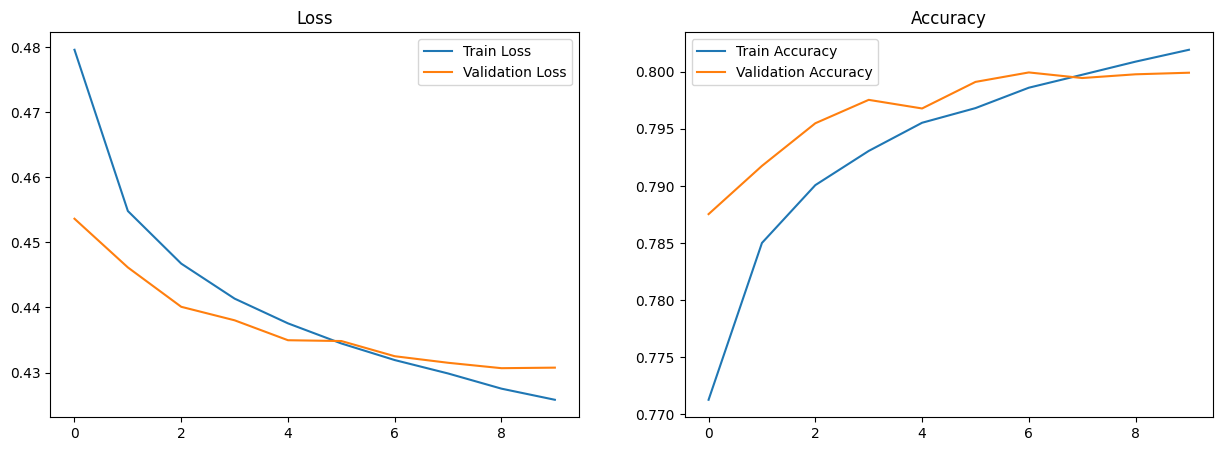

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(train_loss_arr, label='Train Loss')
ax[0].plot(val_loss_arr, label='Validation Loss')
ax[1].plot(train_acc_arr, label='Train Accuracy')
ax[1].plot(val_acc_arr, label='Validation Accuracy')
ax[0].set_title('Loss')
ax[1].set_title('Accuracy')
ax[0].legend()
ax[1].legend()
plt.show()

### 2. Simple Recurrent Neural Network
- RNN utilizes a recurrent structure to "memorize" temporarily the previous tokens.
- It therefore takes into account a very important factor such as positions of the token and represent the sentence as a whole better.

- Instead of processing all the words at once, we would process them on different *timesteps*

In [ ]:
OUTPUT_SIZE = 1
HIDDEN_SIZE = 256
NUM_LAYERS = 3
BATCH_SIZE = 128
NUM_EPOCHS = 30

In [ ]:
class RNNModel(nn.Module):
  def __init__(self, output_size, embedding_dim, hidden_size, num_layers, dropout=0.5):
    super().__init__()
    self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
    self.rnn = nn.RNN(
        input_size = embedding_dim,
        hidden_size = hidden_size,
        num_layers = num_layers,
        nonlinearity = "relu",
        batch_first = True,
        dropout = dropout,
        bidirectional = False,
    )
    self.out_layer = nn.Sequential(
        nn.Dropout(p=dropout),
        nn.Linear(in_features=hidden_size, out_features=output_size, bias=False),
        nn.Sigmoid()
    )

  def forward(self, input):
    emb = self.embedding(input)
    out, h_n = self.rnn(emb)
    out = self.out_layer(out[:, -1, :])
    return out

rnn_model = RNNModel(OUTPUT_SIZE, EMBEDDINGS_DIM, HIDDEN_SIZE, NUM_LAYERS, 0.5).to(device)
print(rnn_model)



RNNModel(

  (embedding): Embedding(248717, 300)

  (rnn): RNN(300, 256, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)

  (out_layer): Sequential(

    (0): Dropout(p=0.5, inplace=False)

    (1): Linear(in_features=512, out_features=1, bias=False)

    (2): Sigmoid()

  )

)


In [ ]:
rnn_loss_fn = nn.BCELoss()
rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr=1e-4, weight_decay=1e-5)
epochs = 10
train_loss_arr, train_acc_arr = [], []
val_loss_arr, val_acc_arr = [], []

for t in range(epochs):
  print(f"Epoch {t+1}\n---------------------------")
  train_loss, train_acc = train_loop(train_loader, rnn_model, rnn_loss_fn, rnn_optimizer)
  val_loss, val_acc = test_loop(val_loader, rnn_model, rnn_loss_fn)
  train_loss_arr.append(train_loss)
  train_acc_arr.append(train_acc)
  val_loss_arr.append(val_loss)
  val_acc_arr.append(val_acc)
print("Done")


Epoch 1

---------------------------

loss: 0.693957 [  128/1432690]

loss: 0.693748 [128128/1432690]

loss: 0.691973 [256128/1432690]

loss: 0.695270 [384128/1432690]

loss: 0.690124 [512128/1432690]

loss: 0.692675 [640128/1432690]

loss: 0.693731 [768128/1432690]

loss: 0.694263 [896128/1432690]

loss: 0.693034 [1024128/1432690]

loss: 0.694681 [1152128/1432690]

loss: 0.693359 [1280128/1432690]

loss: 0.693453 [1408128/1432690]

Test Error:

 Accuracy: 49.98618%, Avg. loss: 0.693151



Epoch 2

---------------------------

loss: 0.693548 [  128/1432690]

loss: 0.693325 [128128/1432690]

loss: 0.693159 [256128/1432690]

loss: 0.693420 [384128/1432690]

loss: 0.692868 [512128/1432690]

loss: 0.693298 [640128/1432690]

loss: 0.692885 [768128/1432690]

loss: 0.692736 [896128/1432690]

loss: 0.693395 [1024128/1432690]

loss: 0.693112 [1152128/1432690]

loss: 0.693395 [1280128/1432690]

loss: 0.693130 [1408128/1432690]

Test Error:

 Accuracy: 50.01382%, Avg. loss: 0.693223



Epoch 3

-

In [ ]:
train_acc_arr = [x.item() for x in train_acc_arr]
val_acc_arr = [x.item() for x in val_acc_arr]

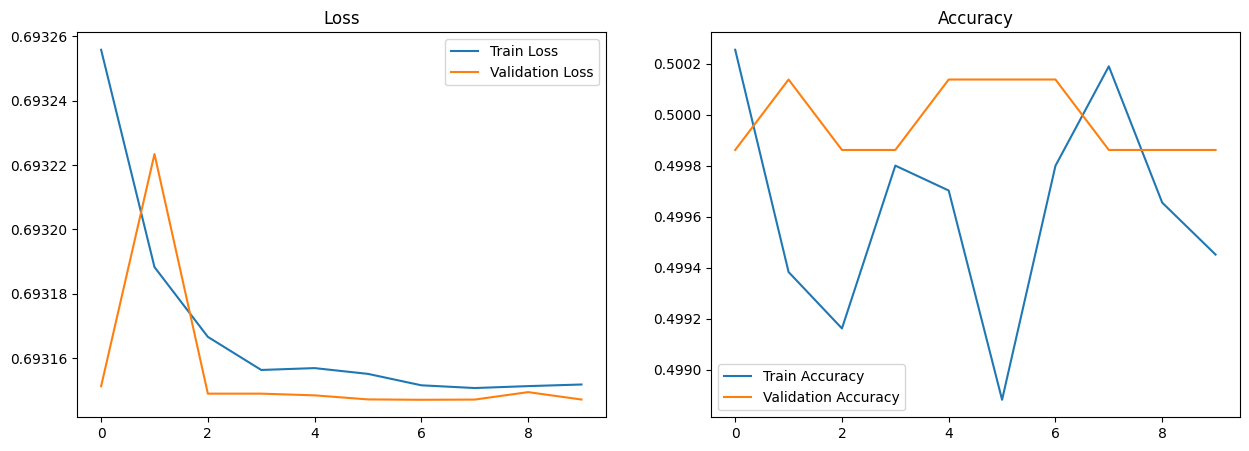

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(train_loss_arr, label='Train Loss')
ax[0].plot(val_loss_arr, label='Validation Loss')
ax[1].plot(train_acc_arr, label='Train Accuracy')
ax[1].plot(val_acc_arr, label='Validation Accuracy')
ax[0].set_title('Loss')
ax[1].set_title('Accuracy')
ax[0].legend()
ax[1].legend()
plt.show()

### 4. GRU Model

In [23]:
OUTPUT_SIZE = 1
HIDDEN_SIZE = 256
NUM_LAYERS = 3
BATCH_SIZE = 128
NUM_EPOCHS = 30

In [24]:
class GRUModel(nn.Module):
  def __init__(self, output_size, embedding_dim, hidden_size, num_layers, dropout=0.5):
    super().__init__()
    self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
    self.lstm = nn.GRU(
        input_size = embedding_dim,
        hidden_size = hidden_size,
        num_layers = num_layers,
        batch_first = True,
        dropout = dropout,
        bidirectional = False,
    )
    self.out_layer = nn.Sequential(
        nn.Dropout(p=dropout),
        nn.Linear(in_features=hidden_size, out_features=output_size, bias=False),
        nn.Sigmoid()
    )

  def forward(self, input):
    emb = self.embedding(input)
    out, h_n = self.lstm(emb)
    out = self.out_layer(out[:, -1, :])
    return out

gru_model = GRUModel(OUTPUT_SIZE, EMBEDDINGS_DIM, HIDDEN_SIZE, NUM_LAYERS, 0.5).to(device)
print(gru_model)


GRUModel(
  (embedding): Embedding(235888, 300)
  (lstm): GRU(300, 256, num_layers=3, batch_first=True, dropout=0.5)
  (out_layer): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=256, out_features=1, bias=False)
    (2): Sigmoid()
  )
)


In [25]:
gru_loss_fn = nn.BCELoss()
gru_optimizer = torch.optim.Adam(gru_model.parameters(), lr=1e-4, weight_decay=1e-5)
epochs = 10
train_loss_arr, train_acc_arr = [], []
val_loss_arr, val_acc_arr = [], []

for t in range(epochs):
  print(f"Epoch {t+1}\n---------------------------")
  train_loss, train_acc = train_loop(train_loader, gru_model, gru_loss_fn, gru_optimizer)
  val_loss, val_acc = test_loop(val_loader, gru_model, gru_loss_fn)
  train_loss_arr.append(train_loss)
  train_acc_arr.append(train_acc)
  val_loss_arr.append(val_loss)
  val_acc_arr.append(val_acc)
print("Done")

Epoch 1
---------------------------
loss: 0.690918 [  128/1431702]
loss: 0.430229 [128128/1431702]
loss: 0.452317 [256128/1431702]
loss: 0.451503 [384128/1431702]
loss: 0.529565 [512128/1431702]
loss: 0.523340 [640128/1431702]
loss: 0.445339 [768128/1431702]
loss: 0.553133 [896128/1431702]
loss: 0.379858 [1024128/1431702]
loss: 0.455613 [1152128/1431702]
loss: 0.514949 [1280128/1431702]
loss: 0.457492 [1408128/1431702]
Test Error:
 Accuracy: 78.20063%, Avg. loss: 0.455776

Epoch 2
---------------------------
loss: 0.393773 [  128/1431702]
loss: 0.464772 [128128/1431702]
loss: 0.394180 [256128/1431702]
loss: 0.449710 [384128/1431702]
loss: 0.513598 [512128/1431702]
loss: 0.563919 [640128/1431702]
loss: 0.412613 [768128/1431702]
loss: 0.421225 [896128/1431702]
loss: 0.422522 [1024128/1431702]
loss: 0.373005 [1152128/1431702]
loss: 0.444917 [1280128/1431702]
loss: 0.403579 [1408128/1431702]
Test Error:
 Accuracy: 79.09956%, Avg. loss: 0.443299

Epoch 3
---------------------------
loss: 0.

In [26]:
train_acc_arr = [x.item() for x in train_acc_arr]
val_acc_arr = [x.item() for x in val_acc_arr]

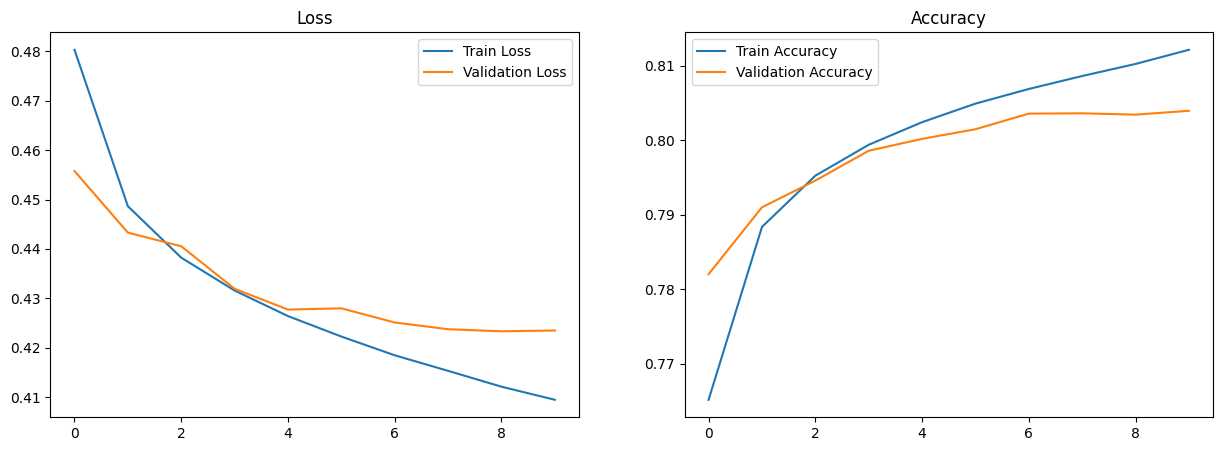

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(train_loss_arr, label='Train Loss')
ax[0].plot(val_loss_arr, label='Validation Loss')
ax[1].plot(train_acc_arr, label='Train Accuracy')
ax[1].plot(val_acc_arr, label='Validation Accuracy')
ax[0].set_title('Loss')
ax[1].set_title('Accuracy')
ax[0].legend()
ax[1].legend()
plt.show()

### 4. LSTM Model

In [ ]:
OUTPUT_SIZE = 1
HIDDEN_SIZE = 256
NUM_LAYERS = 3
BATCH_SIZE = 128
NUM_EPOCHS = 30

In [ ]:
class LSTMModel(nn.Module):
  def __init__(self, output_size, embedding_dim, hidden_size, num_layers, dropout=0.5):
    super().__init__()
    self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
    self.lstm = nn.LSTM(
        input_size = embedding_dim,
        hidden_size = hidden_size,
        num_layers = num_layers,
        batch_first = True,
        dropout = dropout,
        bidirectional = False,
    )
    self.out_layer = nn.Sequential(
        nn.Dropout(p=dropout),
        nn.Linear(in_features=hidden_size, out_features=output_size, bias=False),
        nn.Sigmoid()
    )

  def forward(self, input):
    emb = self.embedding(input)
    out, h_n = self.lstm(emb)
    out = self.out_layer(out[:, -1, :])
    return out

lstm_model = LSTMModel(OUTPUT_SIZE, EMBEDDINGS_DIM, HIDDEN_SIZE, NUM_LAYERS, 0.5).to(device)
print(lstm_model)



LSTMModel(

  (embedding): Embedding(248717, 300)

  (lstm): LSTM(300, 256, num_layers=3, batch_first=True, dropout=0.5)

  (out_layer): Sequential(

    (0): Dropout(p=0.5, inplace=False)

    (1): Linear(in_features=256, out_features=1, bias=False)

    (2): Sigmoid()

  )

)


In [ ]:
lstm_loss_fn = nn.BCELoss()
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-4, weight_decay=1e-5)
epochs = 10
train_loss_arr, train_acc_arr = [], []
val_loss_arr, val_acc_arr = [], []

for t in range(epochs):
  print(f"Epoch {t+1}\n---------------------------")
  train_loss, train_acc = train_loop(train_loader, lstm_model, lstm_loss_fn, lstm_optimizer)
  val_loss, val_acc = test_loop(val_loader, lstm_model, lstm_loss_fn)
  train_loss_arr.append(train_loss)
  train_acc_arr.append(train_acc)
  val_loss_arr.append(val_loss)
  val_acc_arr.append(val_acc)
print("Done")


Epoch 1

---------------------------

loss: 0.691372 [  128/1432690]

loss: 0.552451 [128128/1432690]

loss: 0.476418 [256128/1432690]

loss: 0.481713 [384128/1432690]

loss: 0.515551 [512128/1432690]

loss: 0.409257 [640128/1432690]

loss: 0.446594 [768128/1432690]

loss: 0.487391 [896128/1432690]

loss: 0.445351 [1024128/1432690]

loss: 0.415654 [1152128/1432690]

loss: 0.393490 [1280128/1432690]

loss: 0.394007 [1408128/1432690]

Test Error:

 Accuracy: 79.45322%, Avg. loss: 0.438565



Epoch 2

---------------------------

loss: 0.378535 [  128/1432690]

loss: 0.408158 [128128/1432690]

loss: 0.397880 [256128/1432690]

loss: 0.398445 [384128/1432690]

loss: 0.424585 [512128/1432690]

loss: 0.399774 [640128/1432690]

loss: 0.457222 [768128/1432690]

loss: 0.519269 [896128/1432690]

loss: 0.449658 [1024128/1432690]

loss: 0.424301 [1152128/1432690]

loss: 0.439209 [1280128/1432690]

loss: 0.491604 [1408128/1432690]

Test Error:

 Accuracy: 80.77242%, Avg. loss: 0.420531



Epoch 3

-

In [ ]:
train_acc_arr = [x.item() for x in train_acc_arr]
val_acc_arr = [x.item() for x in val_acc_arr]

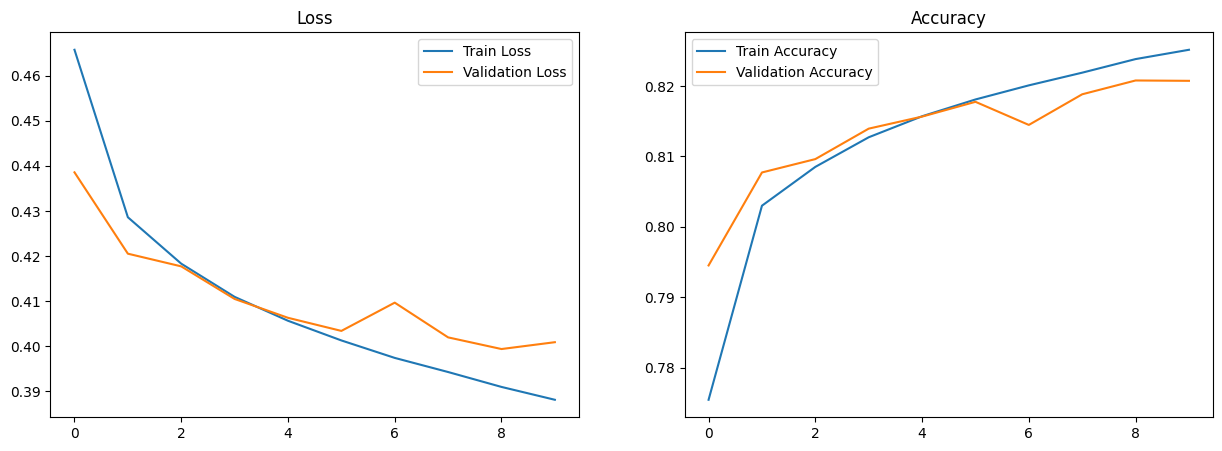

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(train_loss_arr, label='Train Loss')
ax[0].plot(val_loss_arr, label='Validation Loss')
ax[1].plot(train_acc_arr, label='Train Accuracy')
ax[1].plot(val_acc_arr, label='Validation Accuracy')
ax[0].set_title('Loss')
ax[1].set_title('Accuracy')
ax[0].legend()
ax[1].legend()
plt.show()